# Ikeda eddy damping

# Purpose
Investigate the implementation of the eddy damping 

# Methodology
Following the sectional eddy damping published in <cite data-cite="7505983/4AFVVGNT"></cite>.

![](ikeda_eddy_section_A.PNG)
<div class="cite2c-biblio"></div>

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

#%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
from rolldecayestimators import ikeda_speed
from rolldecayestimators.ikeda_naked import eddy_sections
import rolldecayestimators.ikeda_naked as ikeda_naked
#from rolldecayestimators.ikeda_speed import eddy_sections

from rolldecayestimators import simplified_ikeda
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from src.helpers import calculate_lewis,calculate_B_star_hat

# Load digitalized ikeda results

In [3]:
import json

def load_digitalized(file_path:str):
    
    with open(file_path, mode='r') as file:
        j = json.load(file)
    
    df = pd.DataFrame()
    for dataset in j['datasetColl']:
        df_ = load_dataset(dataset=dataset)
        df = df.append(df_)
        
    return df

def load_dataset(dataset):
    
    name = dataset['name']
    
    xs = []
    ys = []
    for data in dataset['data']:
        x = float(data['value'][0])
        y = float(data['value'][1])
        xs.append(x)
        ys.append(y)
        
    df = pd.DataFrame()
    df['x'] = xs
    df['y'] = ys
    df['x'] = df['x'].astype(float)
    df['y'] = df['y'].astype(float)
    
    df['name'] = name
    
    return df

In [4]:
file_paths = {
'A': '../data/external/ikeda_eddy_section_A_phi_a.json',
'B': '../data/external/ikeda_eddy_section_B_phi_a.json',
'C': '../data/external/ikeda_eddy_section_C_phi_a.json',
'D': '../data/external/ikeda_eddy_section_D_phi_a.json',
}

df_paper = pd.DataFrame()
for model, file_path in file_paths.items():
    df_ = load_digitalized(file_path=file_path)
    df_['model']=model
    df_paper = df_paper.append(df_)

df_paper.rename(columns={
    'x':'phi_a',
    'y':'B_star_hat',
    'name':'w_hat',
    }, inplace=True)
df_paper['w_hat'] = df_paper['w_hat'].astype(float)
df_paper['phi_a'] = df_paper['phi_a'].round(decimals=2)

In [5]:
def B_W_B_F(row):
    mask = ((df_paper.model == row.model) & (df_paper.phi_a==0) & (df_paper.w_hat == row.w_hat))
    df_origo = df_paper.loc[mask]
    if len(df_origo)==0:
        return None
    elif len(df_origo)==1:
        origo = df_origo.iloc[0]
    else:
        raise ValueError('Too many...')
    
    B = origo['B_star_hat']
    return B

In [6]:
df_paper['B_W+B_F'] = df_paper.apply(func=B_W_B_F, axis=1)
df_paper['B_e_star_hat'] = df_paper['B_star_hat'] - df_paper['B_W+B_F']
mask = df_paper['phi_a'] != 0
df_paper = df_paper.loc[mask].copy()  # Dropping the zeros

In [7]:
df_paper

,phi_a,B_star_hat,w_hat,model,B_W+B_F,B_e_star_hat
1,0.23,0.041169,0.751,A,0.003636,0.037534
1,0.24,0.029803,0.507,A,0.001391,0.028413
1,0.30,0.023966,0.751,B,0.003265,0.020700
1,0.30,0.014438,0.536,B,0.001111,0.013328
1,0.27,0.008265,0.751,C,0.002115,0.006151
1,0.21,0.005487,0.625,C,0.001500,0.003987
1,0.31,0.009504,0.939,D,0.002039,0.007466
1,0.31,0.007645,0.751,D,0.001500,0.006145


In [8]:
df = pd.read_csv('../data/external/ikeda_eddy._sections.csv', sep=';', index_col=0)
df.head()

,L,B,d,volume,H0,sigma,OG/d,R
No,,,,,,,,
A,0.8,0.280,0.112,0.02509,1.250,1.000,0.000,0.00
B,0.8,0.280,0.112,0.02501,1.250,0.997,0.000,0.01
C,0.8,0.280,0.112,0.02495,1.250,0.995,0.000,0.02
D,0.8,0.280,0.112,0.02475,1.250,0.988,0.000,0.03
E,0.8,0.024,0.070,0.00116,0.171,0.866,-1.753,NaN


# Model A

In [9]:
parameters = df.loc['A']

In [10]:
sigma = parameters.sigma
B_s = np.array([parameters.B])
T_s = parameters.d
S_s = sigma*B_s*T_s
a, a_1, a_3, sigma_s, H = ikeda_speed.calculate_sectional_lewis(B_s=B_s, T_s=T_s, S_s=S_s)

## Journee limits

In [11]:
H

array([1.25])

In [12]:
sigma_min = 3*np.pi/32*(2-1/H)
sigma_min

array([0.35342917])

In [13]:
sigma_max = np.pi/32*(10 + H + 1/H)
sigma_max

array([1.18300598])

It is obvious that a transformation of a half immersed circle with radius R will result in
Ms = R, a1 = 0 and a3 = 0.

In [14]:
ikeda_speed.calculate_sectional_lewis(B_s=2, T_s=1, S_s=np.pi/2)

(array([1.]), array([0.]), array([0.]), array([0.78539816]), array([1.]))

In [15]:
OG=parameters['OG/d']*parameters.d
R = parameters.R 

g = 9.81
rho = 1000

fi_a = 0.175
w_hats = np.linspace(0,1.0,10)

w = lambdas.omega_from_hat(beam=parameters.B, g=g, omega_hat=w_hats)

B_E0_s = eddy_sections(bwl=B_s, a_1=a_1, a_3=a_3, sigma=sigma_s, H0=H, Ts=T_s,
         OG=OG, R=R, wE=w, fi_a=fi_a, ra=1000.0)

B_E0 = B_E0_s*parameters.L

Disp = parameters.volume
B_E0_hat = lambdas.B_to_hat_lambda(B=B_E0, Disp=Disp, beam=B_s, g=g, rho=rho)
B_E0_star_hat = B_E0_hat*3*np.pi/8


In [16]:
B_E0_star_hat

array([[0.        , 0.00297258, 0.00594516, 0.00891774, 0.01189032,
        0.0148629 , 0.01783548, 0.02080806, 0.02378064, 0.02675322]])

<IPython.core.display.Javascript object>


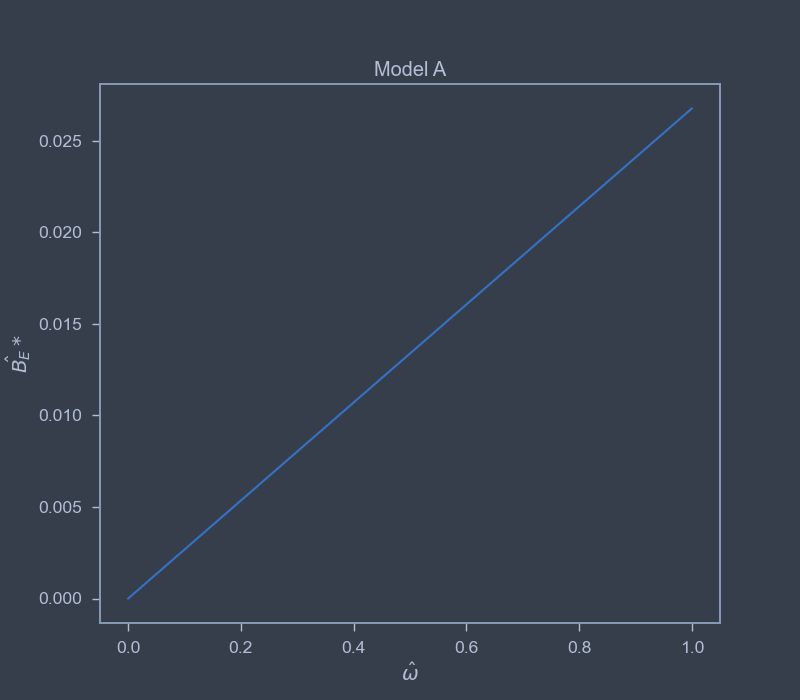

Text(0, 0.5, '$\\hat{B_E}*$')

In [17]:
fig,ax=plt.subplots()
ax.plot(w_hats, B_E0_star_hat[0])
ax.set_title('Model A')
ax.set_xlabel(r'$\hat{\omega}$')
ax.set_ylabel(r'$\hat{B_E}*$')

<IPython.core.display.Javascript object>


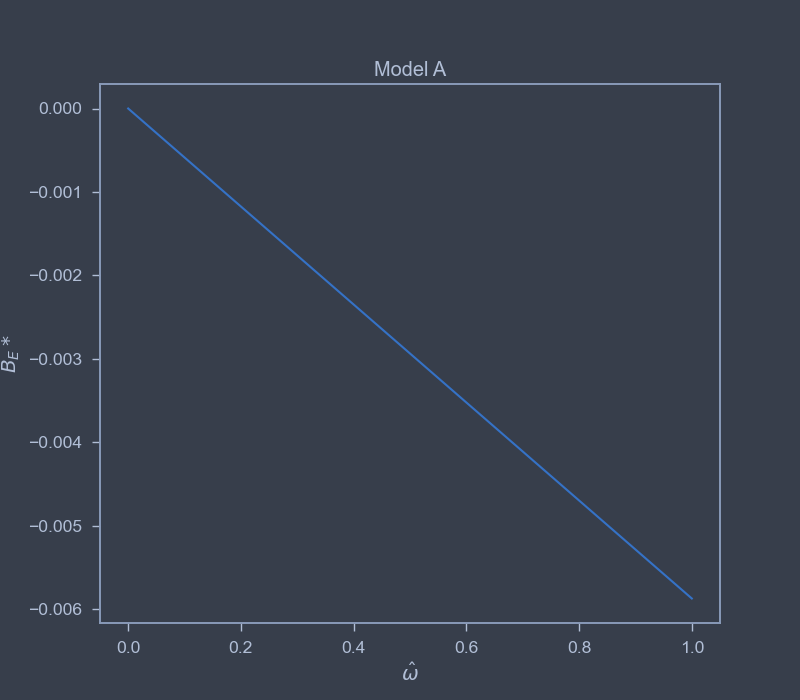

Text(0, 0.5, '$\\hat{B_E}*$')

In [18]:
OG=parameters['OG/d']*parameters.d
R = parameters.R 

g = 9.81
rho = 1000

fi_a = 0.175
w_hats = np.linspace(0,1.0,10)

w = lambdas.omega_from_hat(beam=parameters.B, g=g, omega_hat=w_hats)

BD = parameters['B']/parameters['d']
CB = parameters.volume/(parameters.L*parameters.B*parameters.d)
OGD = OG/parameters.d
PHI = np.rad2deg(fi_a)
B_E0_s = simplified_ikeda.calculate_B_E(BD=BD, CB=CB, CMID=parameters.sigma, OGD=OGD, OMEGAHAT=w_hats,
                                        PHI=PHI)

fig,ax=plt.subplots()
ax.plot(w_hats, B_E0_s)
ax.set_title('Model A')
ax.set_xlabel(r'$\hat{\omega}$')
ax.set_ylabel(r'$\hat{B_E}*$')

In [19]:
df

,L,B,d,volume,H0,sigma,OG/d,R
No,,,,,,,,
A,0.8,0.280,0.112,0.02509,1.2500,1.000,0.000,0.00
B,0.8,0.280,0.112,0.02501,1.2500,0.997,0.000,0.01
C,0.8,0.280,0.112,0.02495,1.2500,0.995,0.000,0.02
D,0.8,0.280,0.112,0.02475,1.2500,0.988,0.000,0.03
E,0.8,0.024,0.070,0.00116,0.1710,0.866,-1.753,NaN
F,0.8,0.064,0.150,0.00763,0.2100,0.992,-0.800,NaN
G,0.8,0.185,0.192,0.02321,0.4850,0.799,0.000,NaN
H,0.8,0.398,0.193,0.05490,1.0360,0.893,0.000,NaN
I,0.8,0.237,0.096,0.01775,1.2320,0.977,0.000,NaN


In [20]:
df_paper_data = pd.merge(left=df_paper, right=df, how='left', left_on='model', right_index=True)
df_paper_data.reset_index(inplace=True, drop=True)

## Calculate Lewis coefficients

In [21]:
a, a_1, a_3, sigma_s, H = calculate_lewis(df_paper_data)
df_paper_data['a_1'] = a_1
df_paper_data['a_3'] = a_3
df_paper_data['H0'] = H

In [22]:
df_paper_data

,phi_a,B_star_hat,w_hat,model,B_W+B_F,B_e_star_hat,L,B,d,volume,H0,sigma,OG/d,R,a_1,a_3
0,0.23,0.041169,0.751,A,0.003636,0.037534,0.8,0.28,0.112,0.02509,1.25,1.000,0.0,0.00,0.095721,-0.138514
1,0.24,0.029803,0.507,A,0.001391,0.028413,0.8,0.28,0.112,0.02509,1.25,1.000,0.0,0.00,0.095721,-0.138514
2,0.30,0.023966,0.751,B,0.003265,0.020700,0.8,0.28,0.112,0.02501,1.25,0.997,0.0,0.01,0.095950,-0.136454
3,0.30,0.014438,0.536,B,0.001111,0.013328,0.8,0.28,0.112,0.02501,1.25,0.997,0.0,0.01,0.095950,-0.136454
4,0.27,0.008265,0.751,C,0.002115,0.006151,0.8,0.28,0.112,0.02495,1.25,0.995,0.0,0.02,0.096102,-0.135084
5,0.21,0.005487,0.625,C,0.001500,0.003987,0.8,0.28,0.112,0.02495,1.25,0.995,0.0,0.02,0.096102,-0.135084
6,0.31,0.009504,0.939,D,0.002039,0.007466,0.8,0.28,0.112,0.02475,1.25,0.988,0.0,0.03,0.096632,-0.130314
7,0.31,0.007645,0.751,D,0.001500,0.006145,0.8,0.28,0.112,0.02475,1.25,0.988,0.0,0.03,0.096632,-0.130314


In [23]:
df_paper_data['B_e_star_hat_pred'] = df_paper_data.apply(func=calculate_B_star_hat, axis=1)

In [24]:
df_paper_data_ = df_paper_data.copy()
#df_paper_data_['phi_a'] = np.rad2deg(df_paper_data_['phi_a'])

<IPython.core.display.Javascript object>


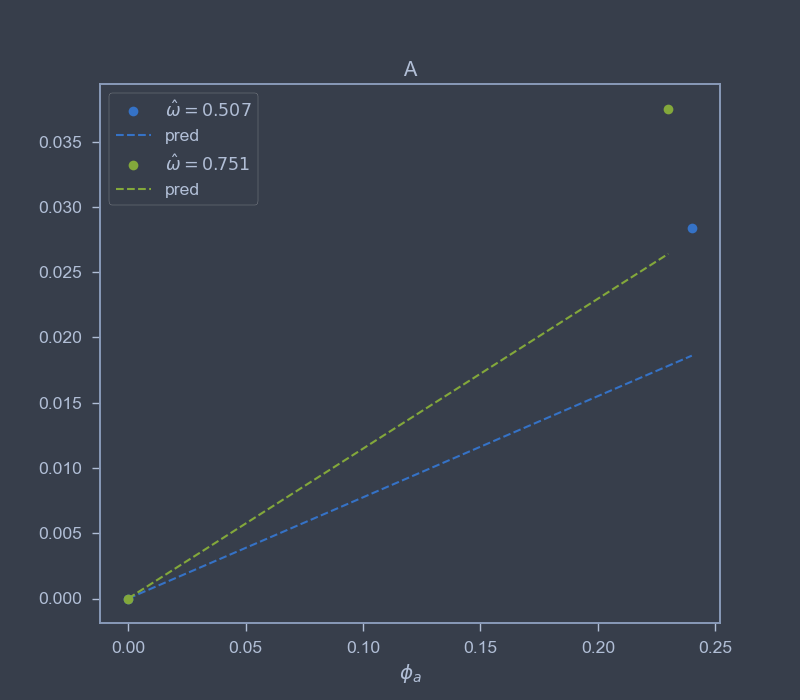

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>


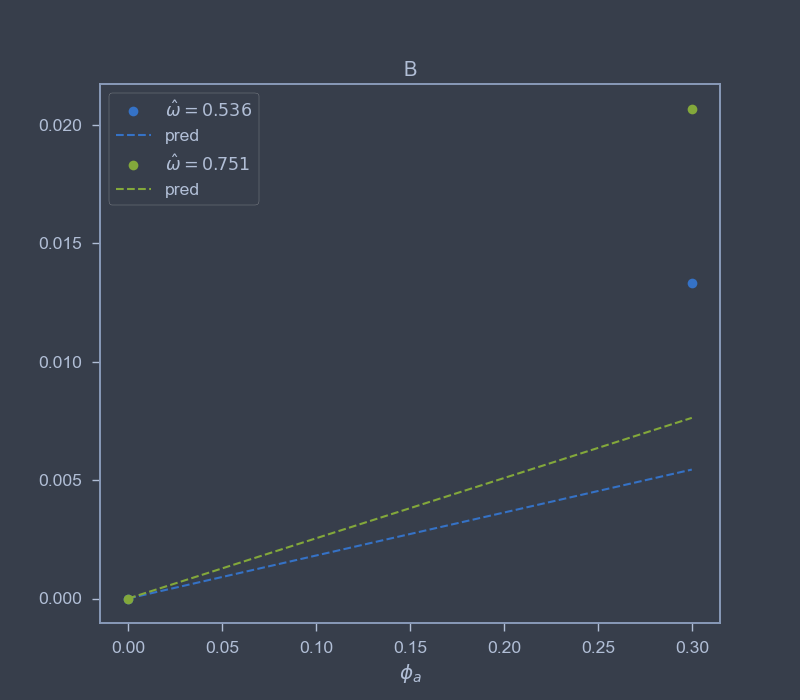

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>


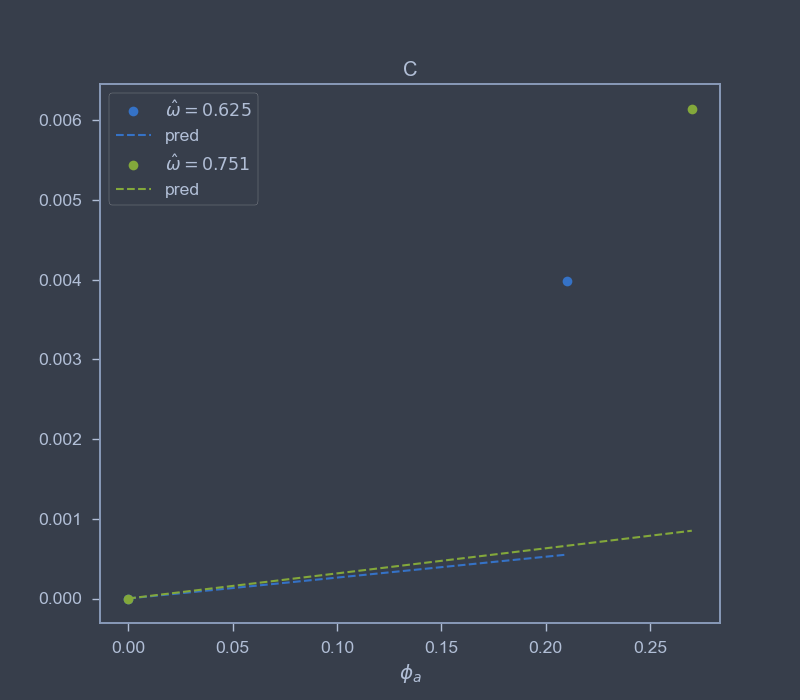

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>


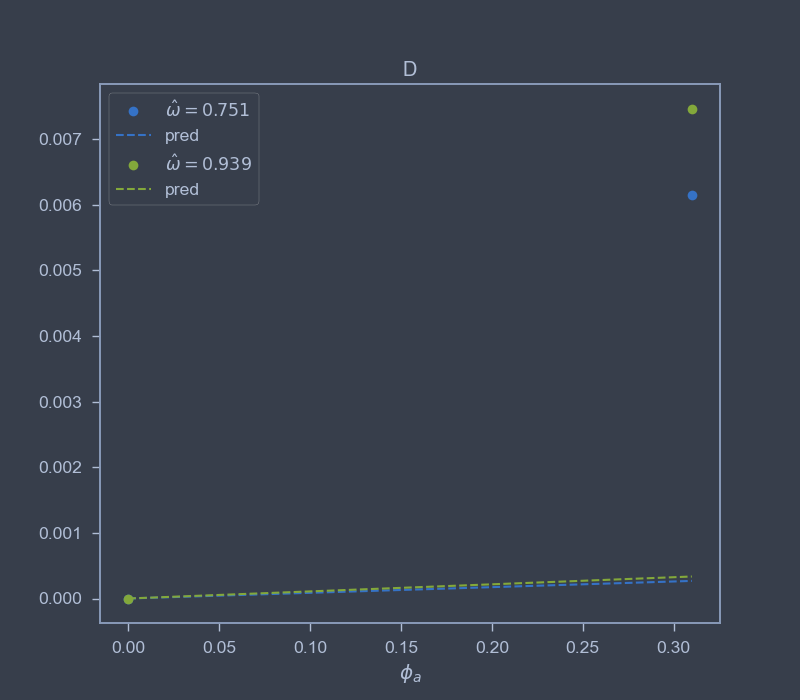

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [25]:
for model_name, model_data in df_paper_data.groupby(by='model'):
    fig,ax=plt.subplots()
    for w_hat, df_ in model_data.groupby(by='w_hat'):
        label = '$\hat{\omega}=%0.3f$' % w_hat
        x = df_['phi_a']
        y = df_['B_e_star_hat']
        lines = ax.plot([0,x], [0,y], 'o', label=label)
        line = lines[-1]
        color = line.get_color()
                
        N=20
        model = df_.iloc[0]
        data = np.tile(model,(N,1))
        df_pred = pd.DataFrame(data=data, columns=model.index)
        df_pred['phi_a'] = np.linspace(0,model.phi_a,N)
        df_pred['B_e_star_hat_pred'] = df_pred.apply(func=calculate_B_star_hat, axis=1)
        df_pred.plot(x='phi_a', y='B_e_star_hat_pred', style='--', color=color, label='pred', ax=ax)
        
    ax.set_xlabel('$\phi_a$')
    ax.legend()
    ax.set_title(model_name)

In [26]:
df_paper_data['k'] = df_paper_data['B_e_star_hat']/df_paper_data['phi_a']
df_paper_data['k_pred'] = df_paper_data['B_e_star_hat_pred']/df_paper_data['phi_a']

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


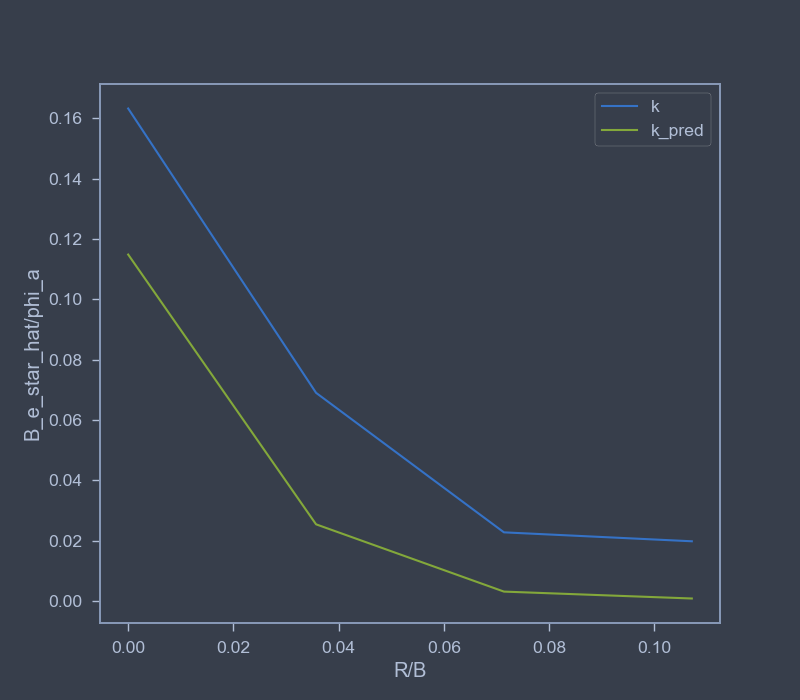

Text(0, 0.5, 'B_e_star_hat/phi_a')

In [27]:
mask = (df_paper_data['w_hat'] == 0.751)
df_changes = df_paper_data.loc[mask]
#df_changes['k_corr'] = df_changes['k_pred'] + 0.04
df_changes['R/B'] = df_changes['R']/df_changes['B']
fig,ax=plt.subplots()
df_changes.plot(x='R/B', y='k', ax=ax)
df_changes.plot(x='R/B', y='k_pred', ax=ax)
#df_changes.plot(x='R/B', y='k_corr', ax=ax)
ax.set_xlabel('R/B')
ax.set_ylabel('B_e_star_hat/phi_a')


<IPython.core.display.Javascript object>


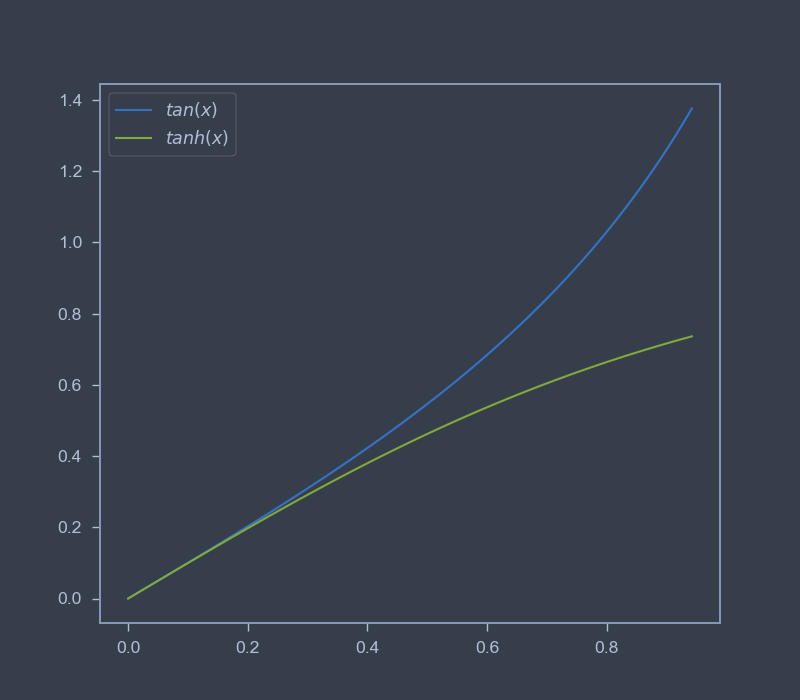

In [28]:
x = np.linspace(0,0.3*np.pi,100)
fig,ax=plt.subplots()
ax.plot(x,np.tan(x), label='$tan(x)$')
ax.plot(x,np.tanh(x), label='$tanh(x)$')
ax.legend()


In [29]:
def estimate_sigma(b,t,R):
    
    A_b = R**2 - R**2*np.pi/4       
    A = b*t - A_b
    sigma = A/(b*t)
    
    return sigma

def estimate_bilge_radius(B,d,sigma,**kwargs):
    A = sigma*B*d  
    r = np.sqrt((B*d-A)/(1-np.pi/4))
    return r



<IPython.core.display.Javascript object>


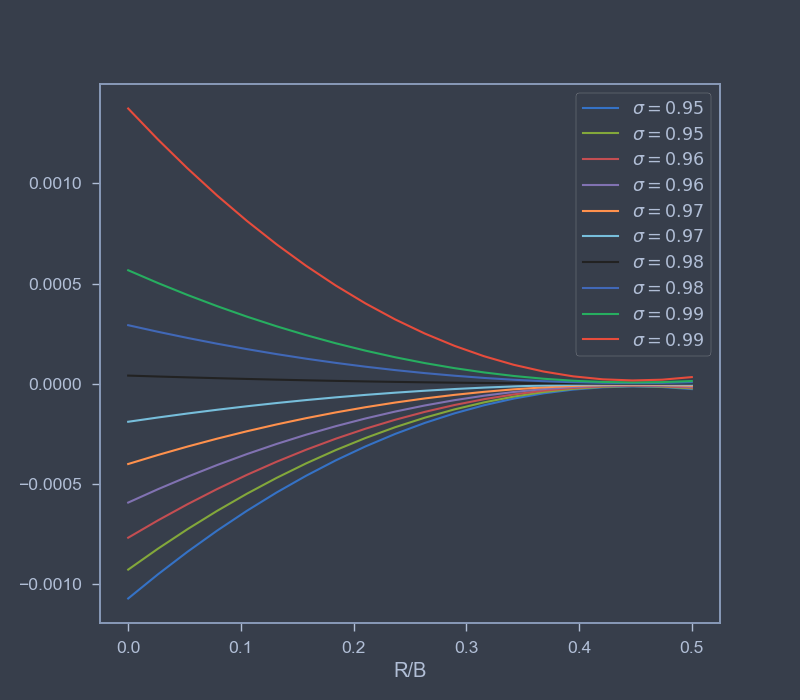

In [30]:
model = df.loc['C']
model['w_hat'] = 0.751
model['phi_a'] = 0.31

N=20
data = np.tile(model,(N,1))
df_ = pd.DataFrame(data=data, columns=model.index)
df_['R/B'] = np.linspace(0,1/2,N)
df_['R'] = model.B*df_['R/B']
df_.set_index('R/B', inplace=True)

fig,ax=plt.subplots()
N=10
for sigma in np.linspace(0.95,0.995,N):
    df_['sigma'] = sigma
    df_['B_e_star_hat_pred'] = df_.apply(func=calculate_B_star_hat, axis=1)
    label = '$\sigma=%0.2f$' % sigma
    df_.plot(y='B_e_star_hat_pred', label = label, ax=ax)


<IPython.core.display.Javascript object>


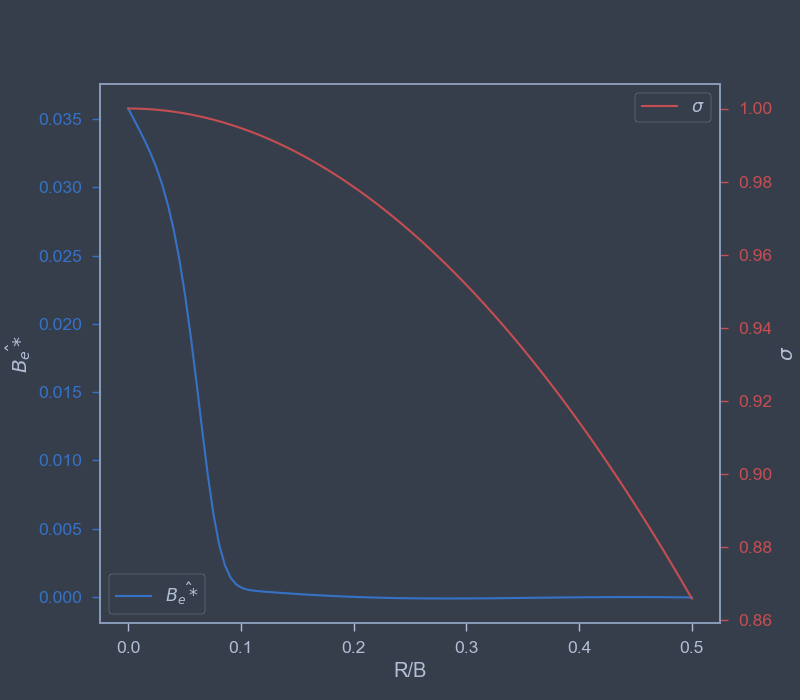

Text(0, 0.5, '$\\sigma$')

In [31]:
model = df.loc['C']
model['w_hat'] = 0.751
model['phi_a'] = 0.31

N=100
data = np.tile(model,(N,1))
df_ = pd.DataFrame(data=data, columns=model.index)
df_['R/B'] = np.linspace(0,1/2,N)
df_['R'] = model.B*df_['R/B']
df_['sigma'] = estimate_sigma(b=df_['B'],t=df_['d'],R=df_['R'])
df_.set_index('R/B', inplace=True)

fig,ax=plt.subplots()
label=r'$\hat{B_e*}$'
ax.set_ylabel(label)
ax.tick_params(axis='y', colors='b')
df_['B_e_star_hat_pred'] = df_.apply(func=calculate_B_star_hat, axis=1)
df_.plot(y='B_e_star_hat_pred', label=label, ax=ax)
ax.legend(loc='lower left')

ax_sigma = ax.twinx()
ax_sigma.tick_params(axis='y', colors='r')
label=r'$\sigma$'
df_.plot(y='sigma', style='r-', label=label, ax=ax_sigma)
ax_sigma.set_ylabel(label)

In [32]:
model = df.loc['A'].copy()
model['w_hat'] = 0.751
model['phi_a'] = 0.31
a, a_1, a_3, sigma_s, H = calculate_lewis(model)
OG=model['OG/d']*model.d
gamma, r_max = ikeda_naked.calculate_gamma(sigma=model.sigma, OG=OG, d=model.d, a_1=a_1, a_3=a_3, H0=H, bwl=model.B)
gamma

array([5.83618791])

<IPython.core.display.Javascript object>


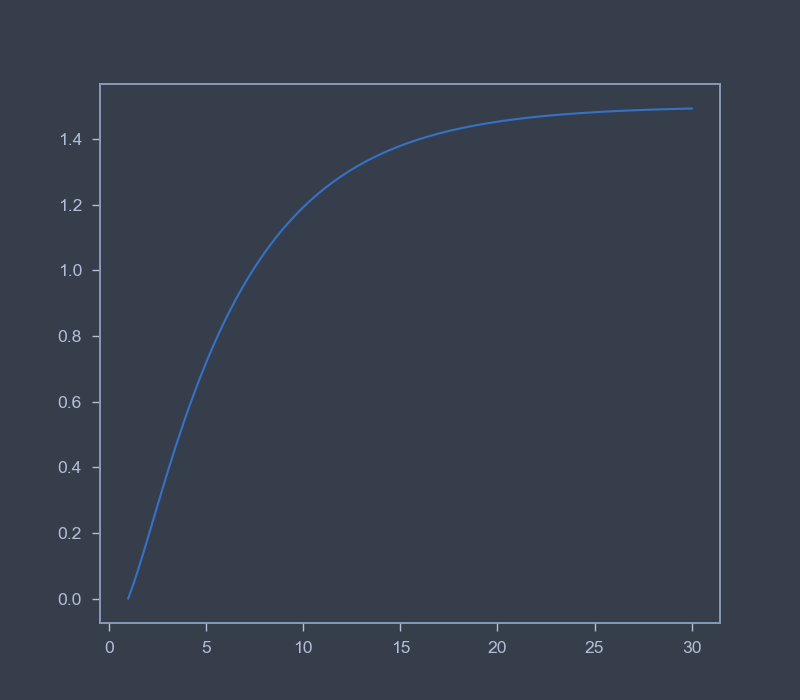

In [33]:
gammas = np.linspace(1,30,100)
C_p = ikeda_naked.calculate_C_p(gammas)
fig,ax=plt.subplots()
ax.plot(gammas, C_p)

<IPython.core.display.Javascript object>


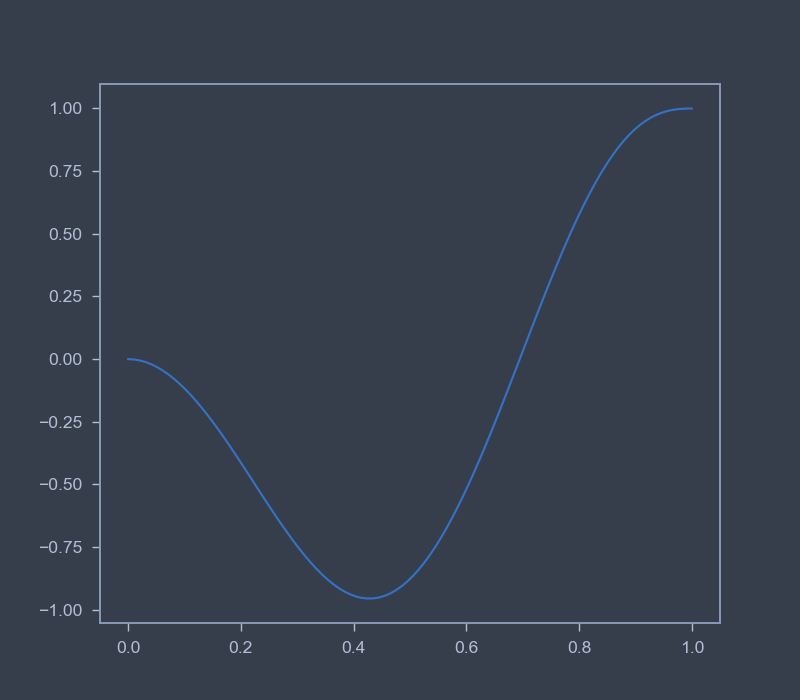

In [34]:
sigmas = np.linspace(0,1,100)
f_2s = ikeda_naked.calculate_f2(sigmas)
fig,ax=plt.subplots()
ax.plot(sigmas, f_2s)

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


<IPython.core.display.Javascript object>


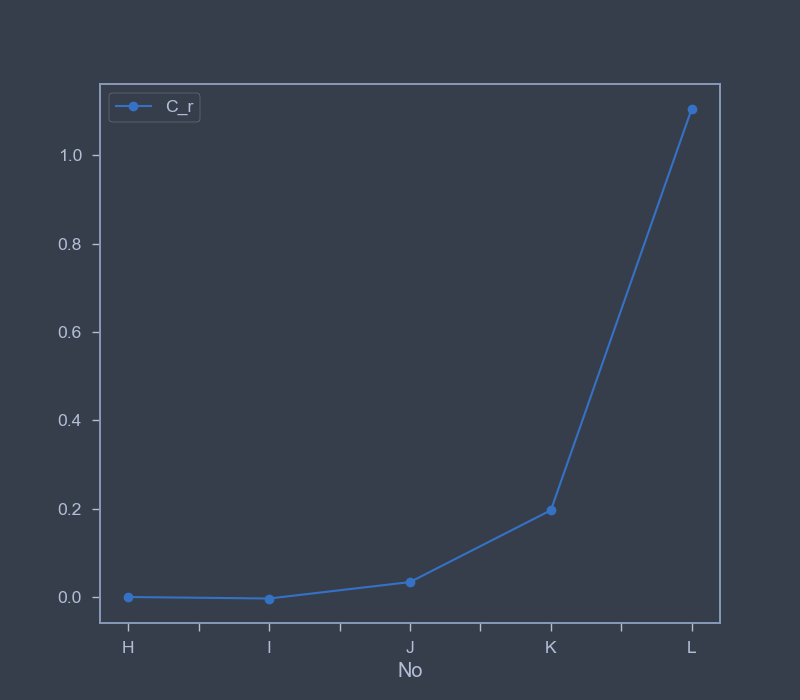

<AxesSubplot:xlabel='No'>

In [43]:
df_series60 = df.loc['G':'L'].copy()
df_series60['R'] = estimate_bilge_radius(**df_series60)

a, a_1, a_3, sigma_s, H = calculate_lewis(df_series60)
df_series60['a_1'] = a_1
df_series60['a_3'] = a_3
df_series60['H0'] = H

OG = df_series60['OG/d']*df_series60.d
ra = 1000
df_series60['C_r'] = ikeda_naked.calculate_C_r(bwl=df_series60.B,
                          a_1=a_1, a_3=a_3, sigma=df_series60.sigma, H0=H, d=df_series60.d, OG=OG, 
                          R=df_series60.R, ra=ra)

df_series60.plot(y='C_r', style='o-')

In [67]:
df_kvlcc2 = pd.read_csv('../data/interim/kvlcc_areas.csv', sep=';', index_col=0)
df_kvlcc2.rename(columns={
    'b':'B',
    't':'d',
    'r_b':'R',
}, inplace=True)
df_kvlcc2['sigma']=df_kvlcc2.area/(df_kvlcc2.B*df_kvlcc2.d)
df_kvlcc2['OG/d']=0  # For now...
sigma_limit = 0.995
mask = df_kvlcc2['sigma']>sigma_limit
df_kvlcc2.loc[mask,'sigma'] = sigma_limit

df_kvlcc2.head()

,area,x,d,B,R,sigma,OG/d
no,,,,,,,
0,13.826612,-5.495000,2.00,11.638577,6.636080,0.593999,0
1,123.851306,10.159932,18.25,27.893522,42.367175,0.243296,0
2,428.211409,28.051284,20.80,41.824284,45.369454,0.492228,0
3,683.709165,43.706216,20.80,50.282514,41.080696,0.653719,0
4,917.895066,61.597568,20.80,56.159232,34.146143,0.785794,0


c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


<IPython.core.display.Javascript object>


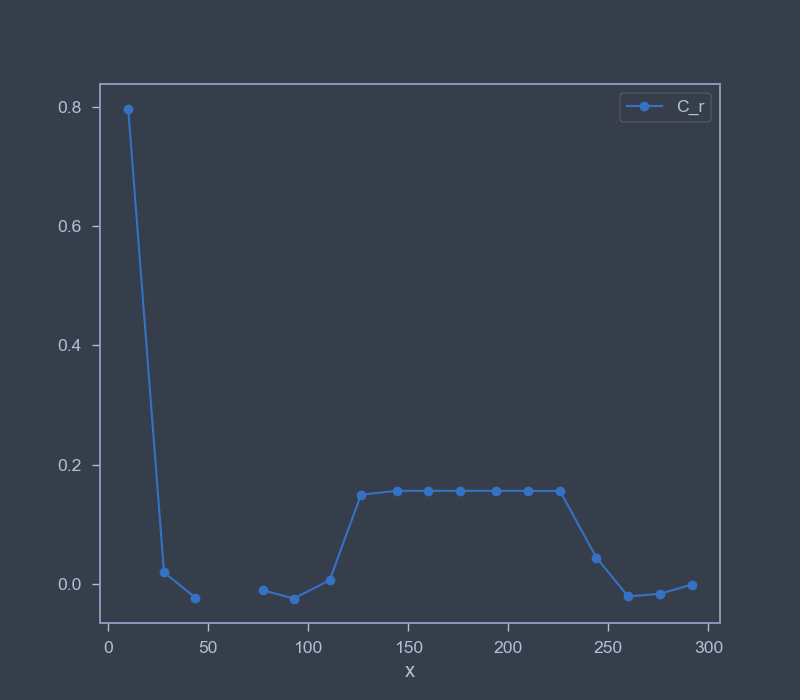

<AxesSubplot:xlabel='x'>

In [68]:
a, a_1, a_3, sigma_s, H = calculate_lewis(df_kvlcc2)
df_kvlcc2['a_1'] = a_1
df_kvlcc2['a_3'] = a_3
df_kvlcc2['H0'] = H

OG = df_kvlcc2['OG/d']*df_kvlcc2.d
ra = 1000
df_kvlcc2['C_r'] = ikeda_naked.calculate_C_r(bwl=df_kvlcc2.B,
                          a_1=a_1, a_3=a_3, sigma=df_kvlcc2.sigma, H0=H, d=df_kvlcc2.d, OG=OG, 
                          R=df_kvlcc2.R, ra=ra)

df_kvlcc2.plot(x = 'x', y='C_r', style='o-')

In [37]:
df_paper_data

,phi_a,B_star_hat,w_hat,model,B_W+B_F,B_e_star_hat,L,B,d,volume,H0,sigma,OG/d,R,a_1,a_3,B_e_star_hat_pred,k,k_pred
0,0.23,0.041169,0.751,A,0.003636,0.037534,0.8,0.28,0.112,0.02509,1.25,1.000,0.0,0.00,0.095721,-0.138514,0.026406,0.163190,0.114810
1,0.24,0.029803,0.507,A,0.001391,0.028413,0.8,0.28,0.112,0.02509,1.25,1.000,0.0,0.00,0.095721,-0.138514,0.018602,0.118385,0.077508
2,0.30,0.023966,0.751,B,0.003265,0.020700,0.8,0.28,0.112,0.02501,1.25,0.997,0.0,0.01,0.095950,-0.136454,0.007631,0.069001,0.025438
3,0.30,0.014438,0.536,B,0.001111,0.013328,0.8,0.28,0.112,0.02501,1.25,0.997,0.0,0.01,0.095950,-0.136454,0.005447,0.044426,0.018155
4,0.27,0.008265,0.751,C,0.002115,0.006151,0.8,0.28,0.112,0.02495,1.25,0.995,0.0,0.02,0.096102,-0.135084,0.000851,0.022780,0.003151
5,0.21,0.005487,0.625,C,0.001500,0.003987,0.8,0.28,0.112,0.02495,1.25,0.995,0.0,0.02,0.096102,-0.135084,0.000551,0.018984,0.002622
6,0.31,0.009504,0.939,D,0.002039,0.007466,0.8,0.28,0.112,0.02475,1.25,0.988,0.0,0.03,0.096632,-0.130314,0.000335,0.024083,0.001081
7,0.31,0.007645,0.751,D,0.001500,0.006145,0.8,0.28,0.112,0.02475,1.25,0.988,0.0,0.03,0.096632,-0.130314,0.000268,0.019822,0.000864


c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_naked.py:138: RuntimeWarning: invalid value encountered in arccos
  psi_2 = 1/2*arccos(a_1*(1+a_3)/(4*a_3))


<IPython.core.display.Javascript object>


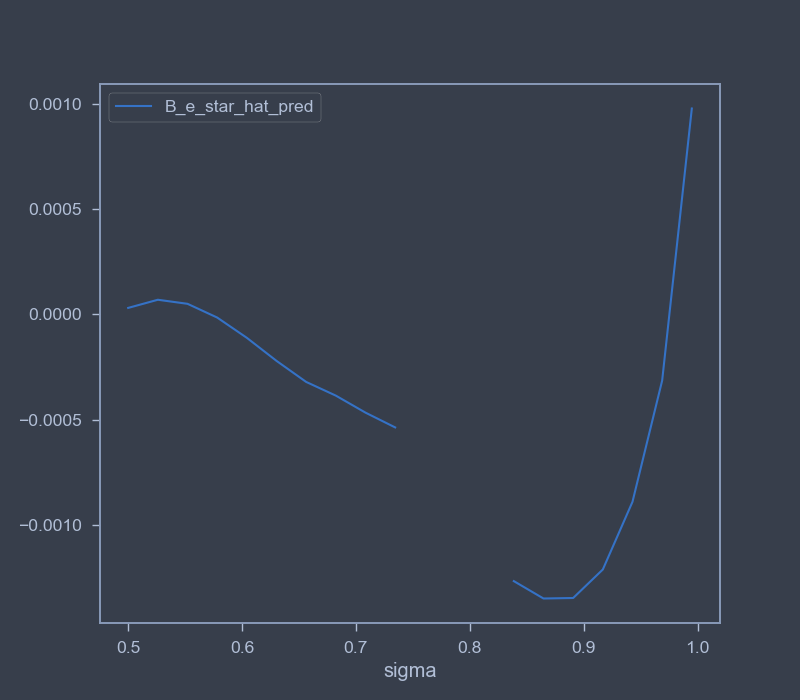

<AxesSubplot:xlabel='sigma'>

In [38]:
model = df.loc['C'].copy()
model['w_hat'] = 0.751
model['phi_a'] = 0.31

N=20
data = np.tile(model,(N,1))
df_ = pd.DataFrame(data=data, columns=model.index)
df_['sigma'] = np.linspace(1/2,model.sigma,N)

df_['B_e_star_hat_pred'] = df_.apply(func=calculate_B_star_hat, axis=1)
df_.set_index('sigma', inplace=True)
fig,ax=plt.subplots()
df_.plot(y='B_e_star_hat_pred', ax=ax)

<IPython.core.display.Javascript object>


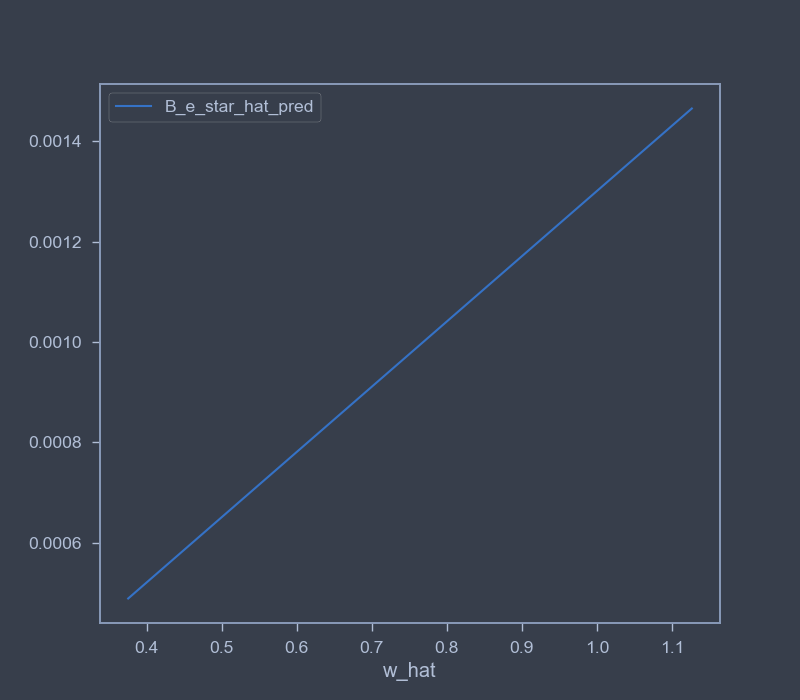

<AxesSubplot:xlabel='w_hat'>

In [39]:
model = df.loc['C'].copy()
model['w_hat'] = 0.751
model['phi_a'] = 0.31

N=20
data = np.tile(model,(N,1))
df_ = pd.DataFrame(data=data, columns=model.index)
key = 'w_hat'
df_[key] = np.linspace(0.5*model.w_hat,1.5*model.w_hat,N)

df_['B_e_star_hat_pred'] = df_.apply(func=calculate_B_star_hat, axis=1)
df_.set_index(key, inplace=True)
fig,ax=plt.subplots()
df_.plot(y='B_e_star_hat_pred', ax=ax)